In [1]:
#mass spring system KF vs RNN comparison
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping
from numpy import linalg
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, lti, dlti, dstep
import scipy.integrate
import time
from mpl_toolkits import mplot3d
import matplotlib
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset 
import os

2025-06-27 16:49:35.108541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751057375.128623  300330 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751057375.134891  300330 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-27 16:49:35.155328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.config.list_physical_devices())
start=time.time()

# Simulation variables
seq_length = 301 # Number of time steps in each sequence
num_records = 100 # Number of sequences to generate
dim_y =1 # Degrees of freedom (number of connected masses) # No. of measured states
dim_x= 2*dim_y # Number of states

# Arrays to store results
X_data_array = np.empty((num_records, seq_length, dim_x))
Y_data_array = np.zeros((num_records, seq_length, dim_y))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [3]:
# Continuous-time model
# Parameters 

# Masses (kg)
m = np.ones(dim_y)
m = 10*m

# Spring constants (N/m)
k = np.ones(dim_y)
k = 800*k

# Damping factors (Ns/m)
d = np.ones(dim_y)
d = 6*d

# State-space
A_c = np.zeros((dim_x,dim_x))

offset = 0
for i in range(dim_x):
    if i % 2 == 0:
        A_c[i,i+1] = 1

    if i % 2 == 1:
        if i != dim_x-1:
            A_c[i,i-1] = -(k[i-1-offset]+k[i-offset])/m[i-1-offset]
            A_c[i,i] = -(d[i-1-offset]+d[i-offset])/m[i-1-offset]
            A_c[i,i+1] = k[i-offset]/m[i-1-offset]
            A_c[i,i+2] = d[i-offset]/m[i-1-offset]
        else:
            A_c[i,i-1] = -k[i-dim_y]/m[i-dim_y]
            A_c[i,i] = -d[i-dim_y]/m[i-dim_y]

        if i != 1:
            A_c[i,i-3] = k[i-1-offset]/m[i-1-offset]
            A_c[i,i-2] = d[i-1-offset]/m[i-1-offset]
        
        offset += 1

B_c = np.zeros((dim_x,dim_y))

H_c = np.zeros((dim_y,dim_x))
offset = 0
for i in range(dim_y):
    H_c[i,i+offset] = 1

    offset += 1

D_c = np.array([[0.]])

In [4]:
# Discretize LTI system using zero-order hold method
dt = 0.1 # Sampling time (seconds)
d_system = cont2discrete((A_c, B_c, H_c, D_c),dt)
A = d_system[0] # Process matrix
H = d_system[2] # Measurement matrix`
print(np.linalg.eig(A))
print(A)

def is_schur(matrix):
    # Check eigenvalues
    eigenvalues, _ = np.linalg.eig(matrix)
    if np.all(np.abs(eigenvalues) < 1):
        print(np.abs(eigenvalues))
        return True
    else:
        return False
    
if is_schur(A):
    print("The matrix is Schur.")
else:
    print("The matrix is not Schur.")

EigResult(eigenvalues=array([0.60784633+0.75649677j, 0.60784633-0.75649677j]), eigenvectors=array([[-0.00372678-0.11104859j, -0.00372678+0.11104859j],
       [ 0.99380799+0.j        ,  0.99380799-0.j        ]]))
[[ 0.63323429  0.08462653]
 [-6.77012211  0.58245838]]
[0.97044553 0.97044553]
The matrix is Schur.


In [5]:
# Noise parameters
mu_pn = np.zeros(dim_x) #mean of process noise
sigma_p = 0.01 # Standard deviation of process noise
sigma_p_diag = (sigma_p**2)*np.ones(dim_x)
Q = np.diag(sigma_p_diag)

mu_mn=np.zeros(dim_y) #mean of measurement noise
sigma_m = 0.01 # Standard deviation of measurement noise
sigma_m_diag = (sigma_m**2)*np.ones(dim_y)
R = np.diag(sigma_m_diag)

sigma_x = 0.01 # Standard deviation of initial state
sigma_x_diag = (sigma_p**2)*np.ones(dim_x)
P = np.diag(sigma_x_diag)

In [6]:
# Simulation
for s in range(num_records):
    mu_x0 = np.random.uniform(-1,1,size=dim_x) # Initial true state
    x=np.random.multivariate_normal(mu_x0,P)
    # Store initial values
    X_data_array[s,0,:] = np.squeeze(np.asarray(x))
    
    for t in range(1,seq_length):
        w = np.random.multivariate_normal(mu_pn,Q)         
        v = np.random.multivariate_normal(mu_mn,R)

        x = A.dot(X_data_array[s,t-1,:]) + w #state at time t
        y = H.dot(x.reshape(-1,1)) + v # Measurement at time t
         
        X_data_array[s,t,:] = x.T # Store true state at time t
        Y_data_array[s,t,:] = y.T # Store measurement at time t

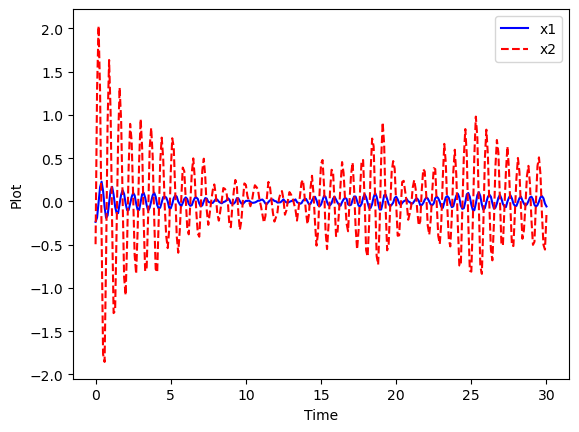

In [7]:
end_t=seq_length*dt
t_span=np.arange(0,end_t,dt)
plt.plot(t_span,X_data_array[0,:,0],'b-',label='x1')
plt.plot(t_span,X_data_array[0,:,1],'r--',label='x2')
plt.ylabel('Plot')
plt.xlabel('Time')
plt.legend(loc='best')
plt.show()

In [8]:
num_data_pts=seq_length*num_records
print(num_data_pts)

30100


In [9]:
num_train_pts=np.floor(0.80*num_records).astype(int)
num_val_pts=np.floor(0.10*num_records).astype(int)
test_data_size=num_records-num_train_pts-num_val_pts

Y_train=Y_data_array[0:num_train_pts,1:,:]
X_train=X_data_array[0:num_train_pts,1:,:]
num_train_plus_val=num_train_pts+num_val_pts

Y_validate=Y_data_array[num_train_pts:num_train_plus_val,1:,:]
X_validate=X_data_array[num_train_pts:num_train_plus_val,1:,:]

Y_test=Y_data_array[num_train_plus_val:num_records,1:,:]
X_test=X_data_array[num_train_plus_val:num_records,1:,:]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Device name:", torch.cuda.get_device_name(0))
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

#proposed rnn implementation
start=time.time()
# Convert data to PyTorch tensors
input_data = torch.tensor(Y_train, dtype=torch.float32)
output_data = torch.tensor(X_train, dtype=torch.float32)

# Define validation data
val_input_data = torch.tensor(Y_validate, dtype=torch.float32)
val_output_data = torch.tensor(X_validate, dtype=torch.float32) 

test_input_data=torch.tensor(Y_test, dtype=torch.float32)
test_output_data=torch.tensor(X_test, dtype=torch.float32)

# Initialize variables for early stopping
best_val_loss = float('inf')  # Set initial best validation loss to infinity
patience = 10  # Number of epochs to wait for improvement
counter = 0  # Counter to track the number of epochs with no improvement
best_epoch = 0 

checkpoint_dir = './ms_torch_checkpoints_jrn'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the model
class JRN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(JRN, self).__init__()
        self.output_size=output_size 
        self.Why = nn.Parameter(torch.empty(hidden_size, output_size))
        nn.init.xavier_uniform_(self.Why)
        self.Wyh = nn.Parameter(torch.empty(output_size, hidden_size))
        self.Wxh = nn.Parameter(torch.empty(input_size, hidden_size))
        nn.init.orthogonal_(self.Wyh)  
        nn.init.orthogonal_(self.Wxh)
        #self.bh = nn.Parameter(torch.zeros(hidden_size))
        #self.by = nn.Parameter(torch.zeros(output_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        y = torch.zeros(batch_size, self.output_size, device=x.device)
        outputs = []
        for i in range(seq_len):
            h = torch.tanh(torch.matmul(x[:, i, :], self.Wxh) + torch.matmul(y, self.Wyh))
            y = torch.matmul(h, self.Why) 
            outputs.append(y.unsqueeze(1))
        return torch.cat(outputs, dim=1)

# Create DataLoader for training data
train_dataset = TensorDataset(input_data, output_data)
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)

# Define the model, loss function, and optimizer
hidden_size = 50
model = JRN(dim_y, hidden_size, dim_x).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-3)

# Training the model
num_epochs = 800
start_time = time.time()
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_Y, batch_X in train_loader:
        batch_Y = batch_Y.to(device)
        batch_X = batch_X.to(device)
        # Forward pass
        all_outputs = model(batch_Y)

        # Compute the loss
        loss = criterion(all_outputs, batch_X)
        total_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_loss = criterion(model(val_input_data.to(device)), val_output_data.to(device))

    # Print and check for early stopping
    print(f'Epoch [{epoch}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss.item():.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_epoch = epoch
        torch.save({'model_state_dict': model.state_dict()}, os.path.join(checkpoint_dir, 'ckpt.pth'))
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1} as validation loss did not improve for {patience} epochs.')
            break

end_time = time.time()
print("Time taken to train JRN:", end_time - start_time)

print("Best Epoch:", best_epoch)

# Restore best model
checkpoint = torch.load(os.path.join(checkpoint_dir, 'ckpt.pth'))
model.load_state_dict(checkpoint['model_state_dict'])

# Test the model
with torch.no_grad():
    predicted_output = model(test_input_data.to(device))
    print("Error in Output:")
    print(predicted_output.to(device) - test_output_data.to(device))


Using device: cuda
Device name: NVIDIA RTX 4500 Ada Generation
Epoch [0], Loss: 0.3889, Val Loss: 0.3149
Epoch [1], Loss: 0.3873, Val Loss: 0.3143
Epoch [2], Loss: 0.3868, Val Loss: 0.3141
Epoch [3], Loss: 0.3864, Val Loss: 0.3133
Epoch [4], Loss: 0.3850, Val Loss: 0.3111
Epoch [5], Loss: 0.3817, Val Loss: 0.3068
Epoch [6], Loss: 0.3755, Val Loss: 0.2995
Epoch [7], Loss: 0.3662, Val Loss: 0.2879
Epoch [8], Loss: 0.3504, Val Loss: 0.2708
Epoch [9], Loss: 0.3274, Val Loss: 0.2493
Epoch [10], Loss: 0.3000, Val Loss: 0.2252
Epoch [11], Loss: 0.2711, Val Loss: 0.1956
Epoch [12], Loss: 0.2290, Val Loss: 0.1525
Epoch [13], Loss: 0.1732, Val Loss: 0.0996
Epoch [14], Loss: 0.1415, Val Loss: 0.1276
Epoch [15], Loss: 0.1316, Val Loss: 0.0857
Epoch [16], Loss: 0.1065, Val Loss: 0.0860
Epoch [17], Loss: 0.1086, Val Loss: 0.0849
Epoch [18], Loss: 0.1051, Val Loss: 0.0774
Epoch [19], Loss: 0.0950, Val Loss: 0.0685
Epoch [20], Loss: 0.0843, Val Loss: 0.0609
Epoch [21], Loss: 0.0748, Val Loss: 0.0568
E

/tmp/ipykernel_300330/3222041587.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, 'ckpt.pth'))


In [11]:
print("time taken to run RNN:")
end=time.time()
print(end-start)
# Output the final weight and bias values
print("Final Weight (Wxh):")
print(model.Wxh)
print("Final Weight (Wyh):")
print(model.Wyh)
print("Final Weight (Why):")
print(model.Why)
#print("Final Bias (bh):")
#print(model.bh)
#print("Final Bias (by):")
#print(model.by)

time taken to run RNN:
36.598021030426025
Final Weight (Wxh):
Parameter containing:
tensor([[ 0.3244, -0.2753, -0.1269, -0.0408, -0.1584,  0.2802, -0.0275, -0.6444,
          0.3257,  0.1613, -0.1282, -0.0043, -0.3064, -0.7804, -0.2217,  0.2642,
          0.3335,  0.3395, -0.3410,  0.2572, -0.1192, -0.1508, -0.5624,  0.2237,
          0.1327,  0.0226,  0.0988,  0.2558,  0.1048,  0.0676,  0.1516,  0.0086,
         -0.1777, -0.0497, -0.1857,  0.0752,  0.0802, -0.0914, -0.1192,  0.2437,
         -0.1248, -0.0121, -0.1080, -0.1146, -0.2430, -0.0537, -0.1094,  0.0961,
         -0.2731,  0.2531]], device='cuda:0', requires_grad=True)
Final Weight (Wyh):
Parameter containing:
tensor([[ 0.0762, -0.1642, -0.3749,  0.3928, -0.2422,  0.0742,  0.5978,  0.5153,
          0.1530,  0.0036, -0.1341, -0.4245, -0.6895, -0.5628, -0.2243, -0.4814,
         -0.1810,  0.3271, -0.3694,  0.2425, -0.1102, -0.2680, -0.5712, -0.1161,
         -0.0018,  0.2115,  0.5165,  0.2399, -0.0656,  0.0099, -0.2073,  0.3596

In [12]:
print(np.shape(predicted_output))
predicted_output=predicted_output.cpu()
predicted_output=predicted_output.numpy()
all_outputs=all_outputs.cpu()
all_outputs=all_outputs.detach().numpy()

torch.Size([10, 300, 2])


In [13]:
# Compute squared error
jrn_squared_error = (predicted_output - X_test) ** 2

# Compute mean squared error over all samples, timesteps, and dimensions
jrn_mse = np.mean(jrn_squared_error)

# Root mean squared error
jrn_rmse = np.sqrt(jrn_mse)

print(f"JRN RMSE: {jrn_rmse}")

JRN RMSE: 0.1939485580529565


In [14]:
# #plotted all timesteps for a few features of each test sequence

# t=[i for i in range(0,seq_length, 1)] #change timesteps here if needful

# sequences=[i for i in range(0,test_data_size,1)]

# for i in range(0,dim_x,1):
#     for se in sequences:
#         print("for test sequence"+str(se+1))
#         fig=plt.figure()
#         fig.set_figwidth(10)
#         fig.set_figheight(5)
#         plt.plot(t, predicted_output[se,t,i], label= "estimated state")
#         plt.plot(t, X_test[se,t,i], label= "true state")
#         plt.title(f"x{i+1}")
#         plt.legend()
#         plt.show()

In [15]:
#implementing a KF for connected springs
start_KF=time.time()
X_hat_t_kf=np.zeros((test_data_size, seq_length, dim_x))#array to store estimated state values

def prediction(X_hat_t_1,P_t_1,Q_t,A):
    X_hat_t=X_hat_t_1
    F_t=np.matrix(A)
    X_hat_t=F_t*X_hat_t
    P_t = F_t*P_t_1*F_t.T + Q_t
    return X_hat_t,P_t

def update(X_hat_t,P_t,Y_t,R_t,H):
    H_t=np.matrix(H)
    S = H_t*P_t*H_t.T + R_t
    K = (P_t*H_t.T) *np.linalg.inv(S)
    z = Y_t - (H_t*X_hat_t) 
    X_t = X_hat_t + (K*z)
    P_t = P_t - (K*H_t*P_t)
    return X_t,P_t

for seq in range(0, test_data_size, 1):
    P_t_minus_1=np.matrix(P)
    Q_t=np.matrix(Q)
    R_t=np.matrix(R)
        
    for timestep in range(1, seq_length, 1):

        X_hat_t_step=np.transpose(np.matrix(X_hat_t_kf[seq,timestep-1,:]))
        Y_t_step=np.matrix(Y_test[seq,timestep-1,:]).T

        X_hat_t_step,P_hat_t=prediction(X_hat_t_step,P_t_minus_1,Q_t,A)

        X_t,P_t=update(X_hat_t_step,P_hat_t,Y_t_step,R_t,H)

        X_hat_t_kf[seq,timestep,:]=np.squeeze(np.asarray(X_t))

        P_t_minus_1=P_t     
end_KF=time.time()
print("Time taken to run KF:")
print(end_KF-start_KF)

Time taken to run KF:
0.20030450820922852


In [16]:
# Extract test portion of X_hat_t_ekf
X_hat_test = X_hat_t_kf[:, 1:, :] 

# Compute squared error
kf_squared_error = (X_hat_test - X_test) ** 2

# Compute mean squared error across all samples, timesteps, and dimensions
kf_mse = np.mean(kf_squared_error)

# Root mean squared error
kf_rmse = np.sqrt(kf_mse)

print(f"KF RMSE: {kf_rmse}")

KF RMSE: 0.19569558283707608


In [17]:
#for plotting absolute error at each timestep averaged over test sequences

test_errors_for_kf=np.zeros((seq_length-1,1))
for k in range(0,seq_length-1,1):
    for i in range(0,test_data_size,1):
        for j in range(0, dim_x, 1):
            test_errors_for_kf[k]+=(X_hat_t_kf[i,k+1,j]-X_test[i,k,j])**2
test_errors_for_kf=test_errors_for_kf/(dim_x*test_data_size)


#for plotting absolute error at each timestep averaged over test sequences

test_errors_for_jrn=np.zeros((seq_length-1,1))
for k in range(0,seq_length-1,1):
    for i in range(0,test_data_size,1):
        for j in range(0, dim_x, 1):
            test_errors_for_jrn[k]+=(predicted_output[i,k,j]-X_test[i,k,j])**2
test_errors_for_jrn=test_errors_for_jrn/(dim_x*test_data_size)


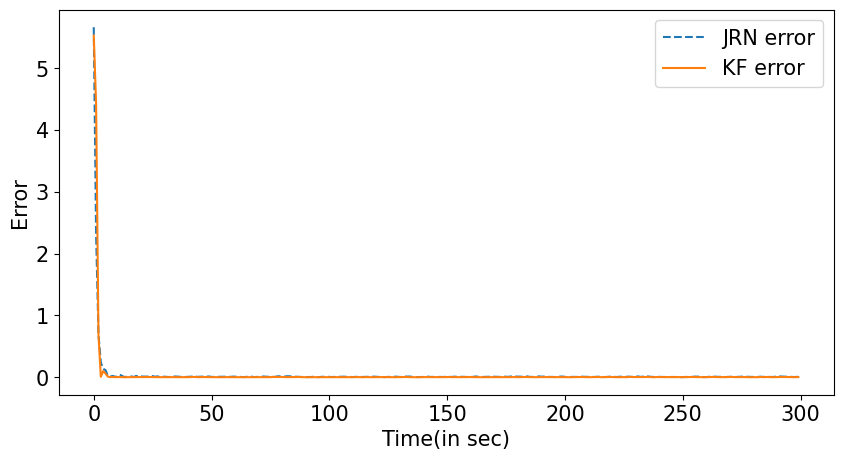

In [18]:
t2=[i for i in range(0,seq_length-1, 1)] #change timesteps here if needful
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

f1=plt.figure()
f1.set_figwidth(10)
f1.set_figheight(5)
plt.plot(t2,test_errors_for_jrn,label="JRN error",linestyle='dashed')
plt.plot(t2,test_errors_for_kf,label="KF error")
#plt.title(f"x{i+1}")
plt.xlabel("Time(in sec)", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.legend(fontsize=15)
plt.show()
f1.savefig("mass_spring_errors.png")
f1.savefig("mass_spring_errors.svg")

In [19]:
print(f"KF RMSE: {kf_rmse}")
print(f"JRN RMSE: {jrn_rmse}")
print(f"Best Epoch: {best_epoch}")

KF RMSE: 0.19569558283707608
JRN RMSE: 0.1939485580529565
Best Epoch: 214


In [20]:
np.savez("ms_data.npz", X_data=X_data_array[:,:,:], Y_data=Y_data_array[:,:,:])